## Cell Model Training

Primary notebook for cell counting efforts that involves 3 primary steps:

1. Select training, validation and un-annotated data
2. Train model and freeze weights in persisted location
3. Load model and apply to un-annotated data

In [1]:
import os
import os.path as osp
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celldom
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from imgaug import augmenters as iaa
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn import model as mrcnn_model
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import cell_dataset
from celldom.dataset import utils as dataset_utils
from celldom.config import cell_config
from celldom.warnings import disable_mrcnn_warnings
from celldom import seed
import wandb
import keras
from wandb.keras import WandbCallback
init_keras_session()
disable_mrcnn_warnings()

dataset_dirs = {
    'dataset03': osp.join(celldom.get_dataset_dir(), 'dataset03', 'ApartmentTraining'),
    'dataset02': osp.join(celldom.get_dataset_dir(), 'dataset02')
}
#model_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.6', 'cell_model')
model_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.7', 'cell_model')
model_path = osp.join(model_dir, 'cell_model.h5')
export_dir = 'results'

# Initialize output directories
os.makedirs(export_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

Using TensorFlow backend.


### Data Partitioning

In [2]:
# Determine all available images for training
data_files = pd.concat([
    dataset_utils.get_data_files(v, patterns=['*.jpeg', '*.jpg']).assign(dataset=k)
    for k, v in dataset_dirs.items()
])
data_files = data_files.reset_index(drop=True)

In [3]:
data_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 5 columns):
image_name      6916 non-null object
image_path      6916 non-null object
annot_path      6916 non-null object
annot_exists    6916 non-null bool
dataset         6916 non-null object
dtypes: bool(1), object(4)
memory usage: 223.0+ KB


In [4]:
data_files.groupby(['dataset', 'annot_exists']).size()

dataset    annot_exists
dataset02  False            664
           True             160
dataset03  False           5412
           True             680
dtype: int64

In [5]:
# Ensure there are no duplicate image entries
if len(data_files) > 0:
    assert data_files['image_name'].value_counts().max() == 1

print(
    'Number of images total = {}, number annotated = {}'
    .format(len(data_files), data_files.annot_exists.sum())
)
data_files.head(3)

Number of images total = 6916, number annotated = 840


,image_name,image_path,annot_path,annot_exists,dataset
0,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03
1,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03
2,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03


In [6]:
# Compute summary statistics about images to help determine the status of each
data_files = cell_dataset.quantify_data_files(data_files, cell_config.CLASS_NAMES)
data_files[data_files.annot_exists].head()

,annot_exists,annot_path,ct:cell,dataset,image_name,image_path,pct:cell_to_cellclump
0,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
1,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
2,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
3,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
4,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN


In [7]:
data_files['pct:cell_to_cellclump'].describe()

count    144.000000
mean       0.950697
std        0.111018
min        0.148410
25%        0.942364
50%        0.969786
75%        1.000000
max        1.000000
Name: pct:cell_to_cellclump, dtype: float64

In [8]:
data_files.groupby('dataset')['ct:cell'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
dataset02,160.0,25.181250,35.800262,0.0,2.0,11.0,34.0,201.0
dataset03,680.0,6.176471,9.184480,1.0,3.0,4.0,5.0,70.0


In [9]:
data_files['ct:cell'].describe()

count    840.000000
mean       9.796429
std       19.155041
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max      201.000000
Name: ct:cell, dtype: float64

In [10]:
# Set any exclusion reasons, if applicable (currently there are none other than the existence of annotations)
PCT_CELL_TO_CELLCLUMP_THRESH = .9

# These images were designated as poorly annotated for one reason or another
IMAGE_BLACKLIST = [
    '/lab/data/celldom/dataset/dataset02/BF_ST_002_APT_007Day4.jpg'
]

def get_exclusion_reason(r):
    if not r['annot_exists']:
        return 'No Annotations'
    
    # Assume that union of cell masks must nearly cover cell clump mask
    if not pd.isnull(r['pct:cell_to_cellclump']) and r['pct:cell_to_cellclump'] < PCT_CELL_TO_CELLCLUMP_THRESH:
        return 'Cell to Clump Ratio < {}'.format(PCT_CELL_TO_CELLCLUMP_THRESH)
    
    # Exclude images with associated annotations but no cell objects as these are problematic with
    # augmentation (empty mask arrays lead to opencv errors)
    if not pd.isnull(r['ct:cell']) and r['ct:cell'] < 1:
        return 'Zero Cells'
    
    # Check image path against blacklist
    if r['image_path'] in IMAGE_BLACKLIST:
        return 'Blacklisted'
    
    return None
    
#data_files['exclusion'] = np.where(data_files['annot_exists'], None, 'No Annotations')
data_files['exclusion'] = data_files.apply(get_exclusion_reason, axis=1)
data_files['exclusion'].fillna('None').value_counts()

No Annotations               6076
None                          814
Zero Cells                     14
Cell to Clump Ratio < 0.9      11
Blacklisted                     1
Name: exclusion, dtype: int64

In [11]:
MODELING_MAX_SAMPLES = len(data_files)
TRAINING_FRACTION = .8

# Determine index corresponding to first MODELING_MAX_SAMPLES records eligible for model (as training or validation records)
idx_modeling = data_files[data_files.exclusion.isnull()].head(MODELING_MAX_SAMPLES).index.values

# Split index into training and validation 
idx_train = pd.Series(idx_modeling).sample(frac=TRAINING_FRACTION, random_state=seed).values
idx_val = np.setdiff1d(idx_modeling, idx_train)

data_files['group'] = 'external'
data_files.loc[idx_train, 'group'] = 'training'
data_files.loc[idx_val, 'group'] = 'validation'

# Summarize and verify counts by training record group
grp_ct = data_files['group'].value_counts()
assert grp_ct['training'] + grp_ct['validation'] == data_files.exclusion.isnull().sum()
assert grp_ct['external'] == data_files.exclusion.notnull().sum()
data_files['group'].value_counts()

external      6102
training       651
validation     163
Name: group, dtype: int64

In [13]:
#'{address}-{cohort}-{ry:02d}-{rx:02d}-{date}-{z}-{my:04d}-{mx:04d}-{patch_idx:02d}.jpeg'
#data_files['image_name'].iloc[0]

In [12]:
data_files.groupby('group')['ct:cell'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
external,26.0,11.115385,19.531159,0.0,0.0,0.0,18.0,86.0
training,651.0,10.059908,20.264431,1.0,3.0,4.0,6.0,201.0
validation,163.0,8.533742,13.840932,1.0,3.0,4.0,6.0,101.0


In [13]:
# Save record of data file categorization for later reference
path = osp.join(export_dir, 'data_files.csv')
data_files.to_csv(path, index=False)
'Data file metadata saved to path {}'.format(path)

'Data file metadata saved to path results/data_files.csv'

## Training

Based on the file categorization above, this section will use all available training + validation data to build a segmentation model:

In [14]:
# Training dataset
train_image_paths = data_files.groupby('group').get_group('training')['image_path'].values
dataset_train = cell_dataset.CellDataset()
dataset_train.initialize(train_image_paths)
dataset_train.prepare()

# # Validation dataset
val_image_paths = data_files.groupby('group').get_group('validation')['image_path'].values
dataset_val = cell_dataset.CellDataset()
dataset_val.initialize(val_image_paths)
dataset_val.prepare()

'Num training images = {}, num validation images = {}'.format(len(train_image_paths), len(val_image_paths))

'Num training images = 651, num validation images = 163'

In [15]:
# Fetch RCNN training configuration
train_config = cell_config.CellTrainingConfig()

# # Set these step counts to equal data size so that a single epoch is easier to describe
# train_config.STEPS_PER_EPOCH = len(train_image_paths)
# train_config.VALIDATION_STEPS = len(val_image_paths)

train_config.STEPS_PER_EPOCH = 100
train_config.VALIDATION_STEPS = 50
    
# Manually set gpu/batch size params
train_config.IMAGES_PER_GPU = 1
train_config.GPU_COUNT = 2
# see: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py
train_config.BATCH_SIZE = train_config.IMAGES_PER_GPU * train_config.GPU_COUNT

train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

#### Augmentation

In [24]:
# Define train-time augmentation
aug = iaa.Sequential([
    iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.CropAndPad((0, 5)),
        iaa.Multiply((0.8, 1.2)),
        iaa.ContrastNormalization((0.5, 2.0)),
        iaa.GaussianBlur(sigma=(0.0, .5))
    ]),
    iaa.Sometimes(0.5, iaa.Affine(
        rotate=(-10, 10),
        #scale=(.9, 1.1)
        scale=(.9, 2.0)
    )),

])

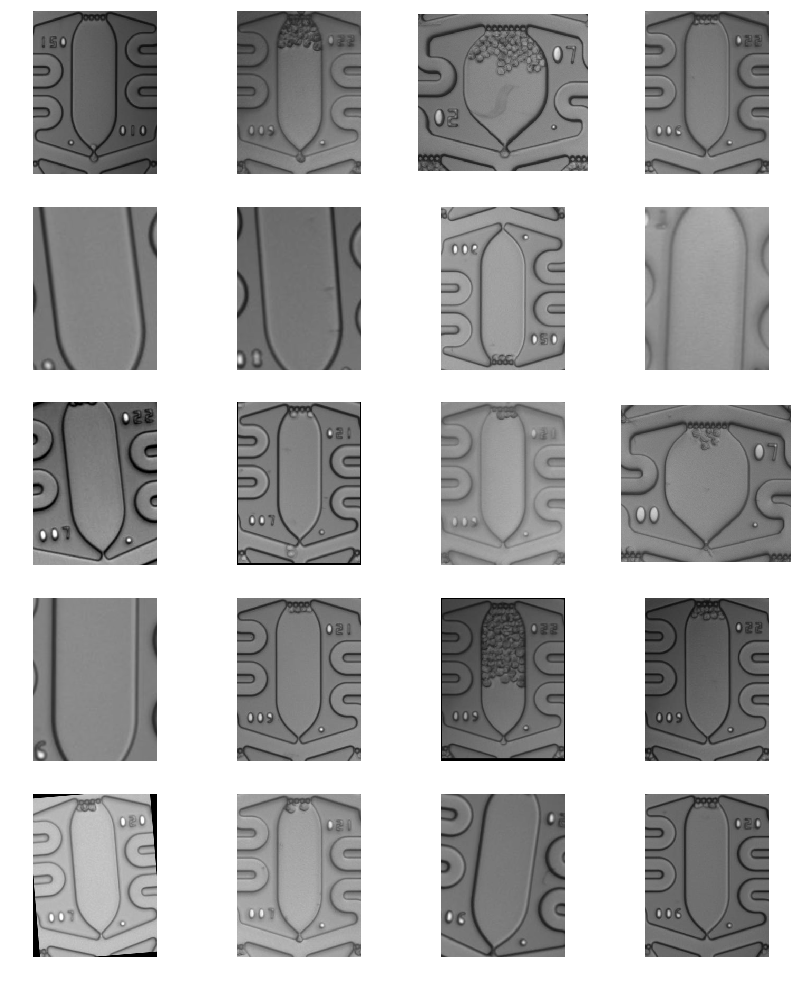

In [25]:
# Show example augmentations
mrcnn_viz.display_images([
    aug.augment_image(dataset_train.load_image(i))
    for i in np.random.choice(np.arange(len(dataset_train.image_ids)), size=20, replace=False)
])

#### Training

In [26]:
model_dir

'/lab/data/celldom/model/r0.7/cell_model'

In [27]:
# NOTE: be careful when clearing the model directory first, as some of the content may be worth saving before re-training
assert model_dir
!rm -rf $model_dir/*
model = mrcnn_model.get_model(
    mode="training", config=train_config, 
    model_dir=model_dir, init_with='coco'
)

In [28]:
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/98wb7oss
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/98wb7oss

In [30]:
%%time
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)

with wandb.monitor(display=False):
    # Run training for small number of epochs (takes about 1 min per epoch on this dataset)
    model.train(
        dataset_train, dataset_val, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=50, 
        layers='heads',
        custom_callbacks=[WandbCallback(save_model=False), early_stopping, learning_rate],
        augmentation=aug
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/98wb7oss



Starting at epoch 0. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

In [31]:
%%time
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)

with wandb.monitor(display=False):
    # Fine tune rest of network
    model.train(
        dataset_train, dataset_val, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=100, 
        layers='all',
        custom_callbacks=[WandbCallback(save_model=False), early_stopping, learning_rate],
        augmentation=aug
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/98wb7oss



Starting at epoch 50. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

In [33]:
!find $model_dir/* | sort | tail -n 10

/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0070.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0071.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0072.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0073.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0074.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0075.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0076.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0077.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0078.h5
/lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0079.h5


In [34]:
model_path

'/lab/data/celldom/model/r0.7/cell_model/cell_model.h5'

In [35]:
!cp /lab/data/celldom/model/r0.7/cell_model/celldom-cell20181004T2329/mask_rcnn_celldom-cell_0079.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "/lab/data/celldom/model/r0.7/cell_model/cell_model.h5"'

## Check Validation Predictions

In [48]:
from cvutils.mrcnn import inference as mrcnn_inference

# Re-initialize model from exported weights in inference mode
inference_config = cell_config.CellInferenceConfig()
inference_config.DETECTION_MIN_CONFIDENCE = .7
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

In [49]:
inference_config.DETECTION_MIN_CONFIDENCE

0.7

In [62]:
import imp
from cvutils.mrcnn import dataset as mrcnn_dataset
imp.reload(mrcnn_dataset)
imp.reload(cell_dataset)
imp.reload(mrcnn_inference)

<module 'cvutils.mrcnn.inference' from '/lab/repos/cvutils/python/cvutils/mrcnn/inference.py'>

In [75]:
# Generate prediction comparisons
pred_gen = mrcnn_inference.prediction_generator(model, dataset_val)

In [76]:
import warnings
preds = None
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Anti-aliasing will be enabled by default in skimage 0.15")
    preds = list(pred_gen)

In [77]:
len(preds)

163

In [78]:
def get_path_to_id(dataset):
    return {
        dataset.source_image_link(image_id): image_id
        for image_id in dataset.image_ids
    }

def get_image_id_sample(dataset, n=10):
    path_to_id = get_path_to_id(dataset)
    records = data_files[data_files['group'] == 'validation'].sort_values('ct:cell', ascending=False).head(n)
    return records['image_path'].map(path_to_id).values

def get_image_ids_from_paths(dataset, paths):
    path_to_id = get_path_to_id(dataset)
    return [path_to_id[p] for p in paths]

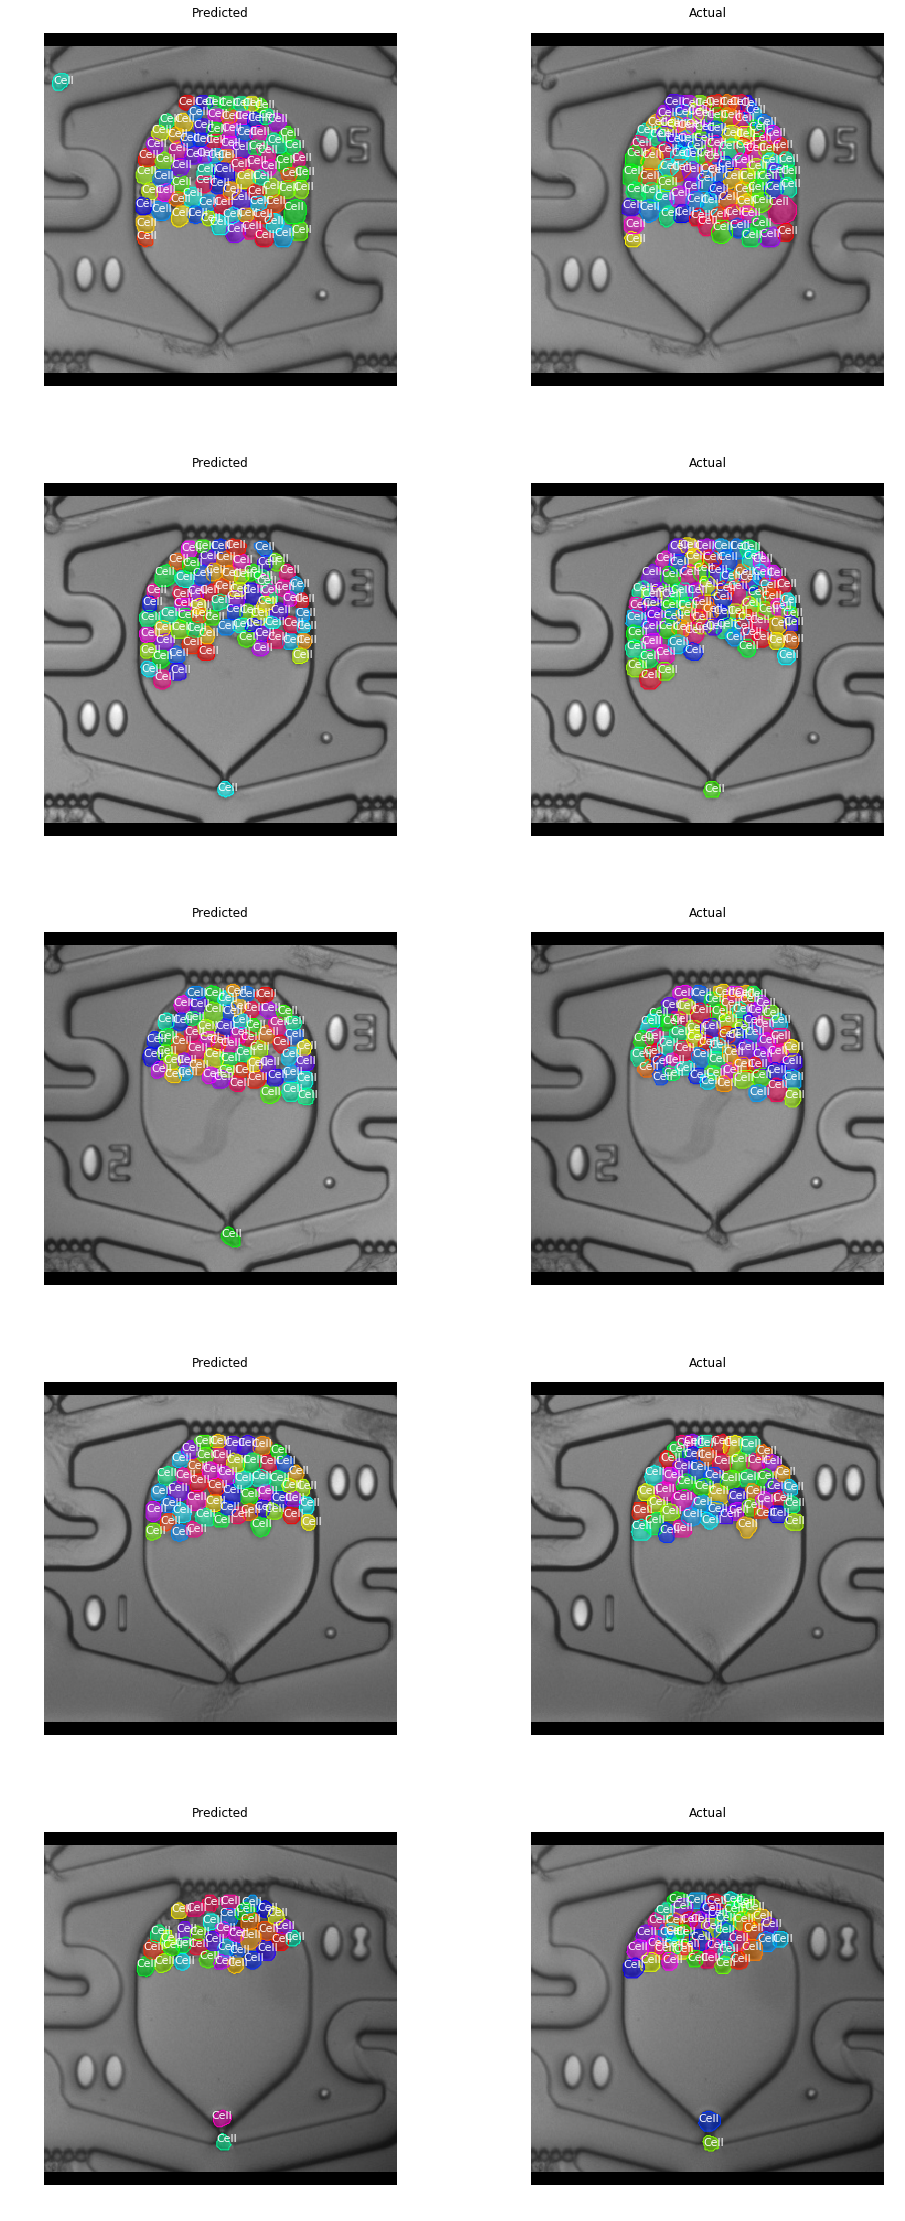

In [79]:
def display_predictions(dataset, n=10, random=False, paths=None, ids=None):
    if ids is not None:
        id_samp = ids
    elif paths is not None:
        id_samp = get_image_ids_from_paths(dataset, paths)
    elif random:
        id_samp = pd.Series(dataset.image_ids).sample(n=n, random_state=1)
    else:
        id_samp = get_image_id_sample(dataset, n=n)
        
    n = len(id_samp)
    fig, ax = plt.subplots(n, 2, squeeze=False)
    for i, image_id in enumerate(id_samp):
        pred = preds[image_id]
        #pred_scores = pred.pred_scores
        pred_scores = None
        mrcnn_viz.display_instances(
            pred.image, pred.pred_rois, pred.pred_masks, pred.pred_class_ids, 
            dataset.class_names, pred_scores, show_bbox=False, figsize=(8, 8), ax=ax[i,0], title='Predicted')
        if pred.true_rois is not None:
            mrcnn_viz.display_instances(
                pred.image, pred.true_rois, pred.true_masks, pred.true_class_ids, 
                dataset.class_names, None, show_bbox=False, figsize=(8, 8), ax=ax[i,1], title='Actual')
        else:
            ax[i, 1].imshow(pred.image)
            ax[i, 1].set_title('Original')
    return fig

nsamples = 5

# Display sample by cell count
fig = display_predictions(dataset_val, n=nsamples)

# Display random sample
#fig = display_predictions(dataset_val, n=nsamples, random=True)

# Display specific examples
# fig = display_predictions(dataset_val, n=nsamples, paths=[
#     '/lab/data/celldom/dataset/dataset02/BF_ST_002_APT_007Day4.jpg'
# ])

fig.set_size_inches(16, nsamples * 8)

In [148]:
def get_counts(preds):
    df = []
    for p in preds:
        true_ct = p.true_masks.shape[-1]
        pred_ct = p.pred_masks.shape[-1]
        # Hack to set chip type
        chip = 'G03' if 'dataset02' in p.image_info else 'G02'
        df.append(dict(image_id=p.image_id, image_path=p.image_info, true_ct=true_ct, pred_ct=pred_ct, chip=chip))
    return pd.DataFrame(df).assign(delta=lambda d: d['pred_ct'] - d['true_ct'])
df_eval = get_counts(preds)
df_eval.head()

,chip,image_id,image_path,pred_ct,true_ct,delta
0,G03,0,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_000Day2.jpg,28,31,-3
1,G03,1,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_001Day0.jpg,3,2,1
2,G03,2,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_001Day2.jpg,17,17,0
3,G03,3,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_002Day1.jpg,12,15,-3
4,G03,4,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_003Day2.jpg,27,28,-1


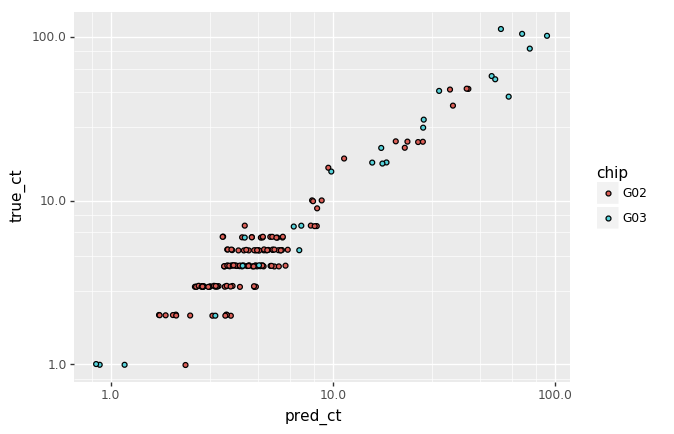

<ggplot: (8746717049264)>

In [149]:
import plotnine as pn
(
    pn.ggplot(df_eval, pn.aes(x='pred_ct', y='true_ct', fill='chip')) + 
    pn.geom_jitter(width=.1) + 
    pn.scale_x_log10() +
    pn.scale_y_log10() 
)

In [150]:
pd.set_option('display.max_colwidth', 1000)
df_eval.assign(absdelta=df_eval['delta'].abs()).sort_values('absdelta', ascending=False).head(5)

,chip,image_id,image_path,pred_ct,true_ct,delta,absdelta
16,G03,16,/lab/data/celldom/dataset/dataset02/BF_ST_002_APT_003Day4.jpg,53,111,-58,58
6,G03,6,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_005Day4.jpg,76,101,-25,25
11,G03,11,/lab/data/celldom/dataset/dataset02/BF_ST_001_APT_001Day3.jpg,83,105,-22,22
5,G03,5,/lab/data/celldom/dataset/dataset02/BF_ST_000_APT_003Day3.jpg,68,85,-17,17
148,G02,148,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806031845-zp3-0267-0341-12.jpeg,33,48,-15,15


In [151]:
df_eval['delta'].describe()

count    163.000000
mean      -1.417178
std        6.009063
min      -58.000000
25%       -1.000000
50%        0.000000
75%        0.000000
max       13.000000
Name: delta, dtype: float64

In [152]:
df_eval.groupby('chip')['delta'].describe()

,count,mean,std,min,25%,50%,75%,max
chip,,,,,,,,
G02,138.0,-0.565217,2.327106,-15.0,-1.0,0.0,0.0,2.0
G03,25.0,-6.120000,13.623876,-58.0,-9.0,-1.0,0.0,13.0


### External Validation

In [153]:
# External dataset
ext_image_paths = data_files.groupby('group').get_group('external')['image_path'].values
dataset_ext = cell_dataset.CellDataset()
dataset_ext.initialize(ext_image_paths)
dataset_ext.prepare()

In [154]:
pd.set_option('display.max_colwidth', 1000)
df_ext = pd.DataFrame(dict(path=ext_image_paths, idx=np.arange(len(ext_image_paths))))
df_ext[df_ext['path'].str.contains('NoDrug')].head()

,idx,path
703,703,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-z_0-0261-0340-10.jpeg
704,704,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm3-0261-0339-11.jpeg
705,705,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm6-0262-0339-11.jpeg
706,706,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm9-0262-0339-09.jpeg
707,707,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zp3-0261-0339-08.jpeg


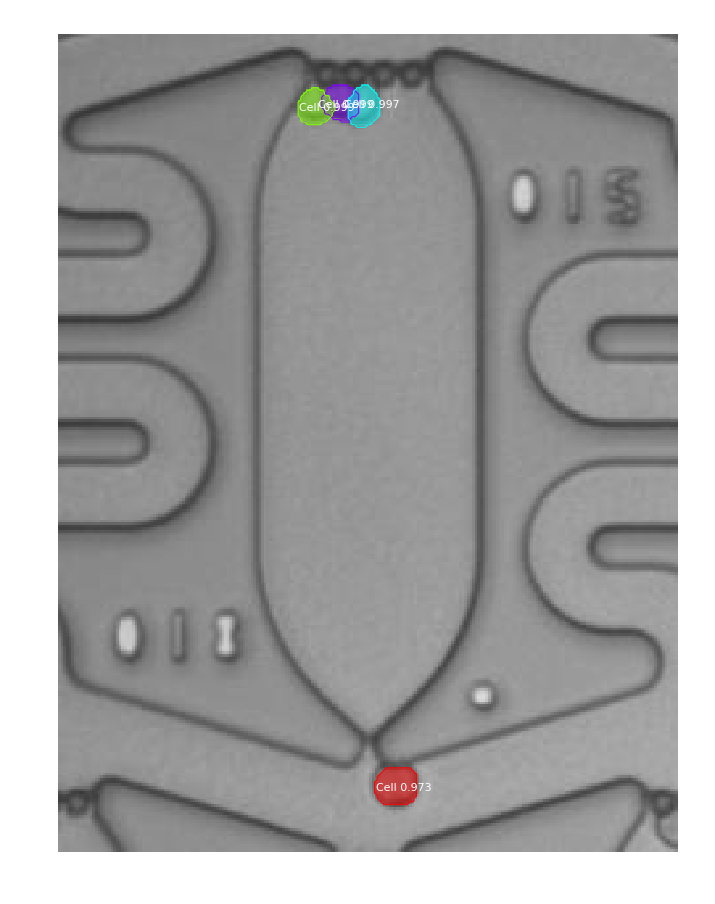

In [166]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Anti-aliasing will be enabled by default in skimage 0.15")
    image_id = np.random.choice(dataset_ext.image_ids, size=1)[0]
    image = dataset_ext.load_image(image_id)
    r = model.detect([image])[0]
    mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_ext.class_names, r['scores'], show_bbox=False)